In [1]:
import numpy as np
import SimpleITK as sitk
import os
import torch
import matplotlib.pyplot as plt
from propagate_labels import run_inference
from utils.visualization import *


# set cuda visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

patient = 12 # 1-450
view = '4CH' # 2CH, 4CH

Load sequence and extract two frames

In [2]:
patient_name = f'patient{patient:04d}'
vid_path = f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/{patient_name}/{patient_name}_{view}_sequence.mhd'
vid = sitk.ReadImage(vid_path)
vid = sitk.GetArrayFromImage(vid)
print(f'Patient: {patient_name} ({view})\nVideo shape: {vid.shape}')

Patient: patient0012 (4CH)
Video shape: (22, 843, 512)


Given a fixed image and a moving image, a deformation field is predicted to warp the moving image into the fixed image.
Therefore:
- Moving image: the image to be warped (frame $n$)
- Fixed image: the image to be matched (frame $n+1$)

In [3]:
moving_img = vid[0]
fixed_img = vid[1]

moving_img = torch.FloatTensor(moving_img)	
fixed_img = torch.FloatTensor(fixed_img)

Network contains 132866 trainable parameters.


100%|██████████| 250/250 [00:08<00:00, 29.50it/s]


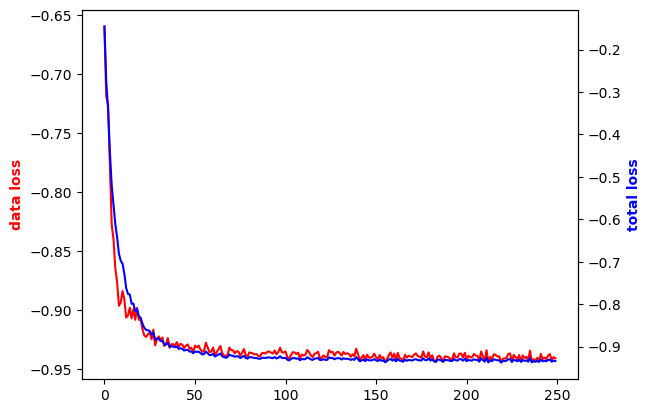

In [184]:
from utils import general
from models import models

out_dir = "prova"

kwargs = {}
kwargs["verbose"] = True
kwargs["save_model"] = False
# kwargs["save_folder"] = os.path.join(out_dir, patient_name + '_' + view)

kwargs["jacobian_regularization"] = True
kwargs["alpha_jacobian"] = 0.05 # default is 0.05

kwargs["bending_regularization"] = True
kwargs["alpha_bending"] = 2 # default is 10

kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"

# make a binary map where moving_img > 10
mask = moving_img > 10

kwargs["mask"] = mask
kwargs["batch_size"] = 4000
kwargs["omega"] = 80
kwargs["epochs"] = 250


# if file 'trained_model.pt' exists in the save_folder, the model will be loaded from there
# otherwise, the model will be trained from scratch
if kwargs["save_model"] and os.path.isfile(os.path.join(kwargs["save_folder"], 'trained_model.pt')):
    kwargs["network"] = os.path.join(kwargs["save_folder"], 'trained_model.pt')
    ImpReg = models.ImplicitRegistrator(moving_img, fixed_img, **kwargs)
else:
    ImpReg = models.ImplicitRegistrator(moving_img, fixed_img, **kwargs)
    ImpReg.fit()

    fix, ax = plt.subplots()
    ax.plot(ImpReg.data_loss_list, color='red')
    # make the label font bold, see below
    ax.set_ylabel('data loss', color='red', fontweight='bold')
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(ImpReg.loss_list, color='blue')
    ax2.set_ylabel('total loss', color='blue', fontweight='bold')
    plt.show()

In [185]:
moving_mask = sitk.ReadImage(f'/home/mtarufo/thesis/supervision_by_registration/data/camus/training/{patient_name}/{patient_name}_{view}_ED_gt.mhd')
moving_mask = sitk.GetArrayFromImage(moving_mask)[0]
moving_mask = torch.FloatTensor(moving_mask)

In [186]:
warped_img = ImpReg(moving_image=moving_img.cuda(), fast=True, ftype='image')
# print(f"==>> warped_img.shape: {warped_img.shape}")
warped_mask, dvf = ImpReg(moving_image=moving_mask.cuda(), fast=False, return_dvf=True, ftype='mask')
# print(f"==>> warped_mask.shape: {warped_mask.shape}")
# print(f"==>> dvf.shape: {dvf.shape}")

# assign [0,0] to dvf in the indices specified by mask
# dvf = dvf * mask.numpy()


Text(0.5, 1.0, 'Vector field')

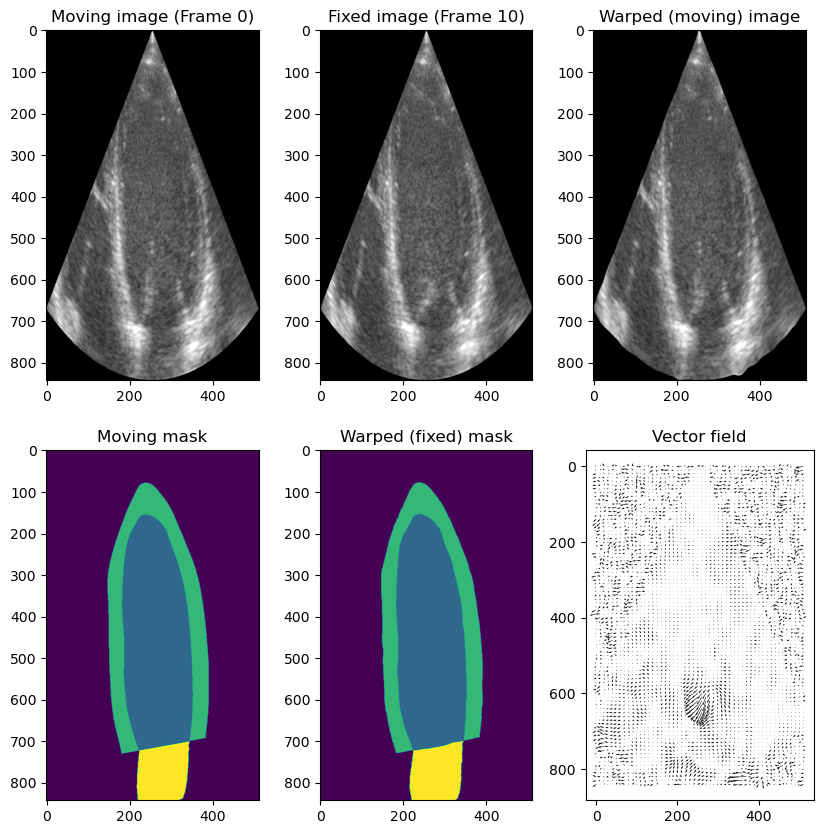

In [187]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
ax[0,0].imshow(moving_img, cmap='gray', vmin=0, vmax=255)
ax[0,0].set_title('Moving image (Frame 0)')
ax[0,1].imshow(fixed_img, cmap='gray', vmin=0, vmax=255)
ax[0,1].set_title('Fixed image (Frame 10)')
ax[0,2].imshow(warped_img, cmap='gray', vmin=0, vmax=1)
ax[0,2].set_title('Warped (moving) image')
ax[1,0].imshow(moving_mask)
ax[1,0].set_title('Moving mask')
ax[1,1].imshow(warped_mask)
ax[1,1].set_title('Warped (fixed) mask')
step = 10 # to downsample the grid
x,y = np.meshgrid(np.arange(0, dvf.shape[2]), np.arange(0,dvf.shape[1]))
u,v = dvf[0], dvf[1]
ax[1,2].quiver(x[::step, ::step],y[::step, ::step],u[::step, ::step],v[::step, ::step])
ax[1,2].invert_yaxis()
ax[1,2].set_title('Vector field')


In [188]:
def plot_grid(u,v, step = 10, ax=None, **kwargs):
    # as seen in https://stackoverflow.com/questions/47295473/how-to-plot-using-matplotlib-python-colahs-deformed-grid
    grid_x, grid_y = np.meshgrid(np.arange(0, u.shape[1], 1), np.arange(0, v.shape[0], 1))
    f = lambda x, y : (x + u, y + v)
    distx, disty = f(grid_x, grid_y)
    ax = ax or plt.gca()
    segs1 = np.stack((distx[::step, ::step], disty[::step, ::step]), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.invert_yaxis()
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

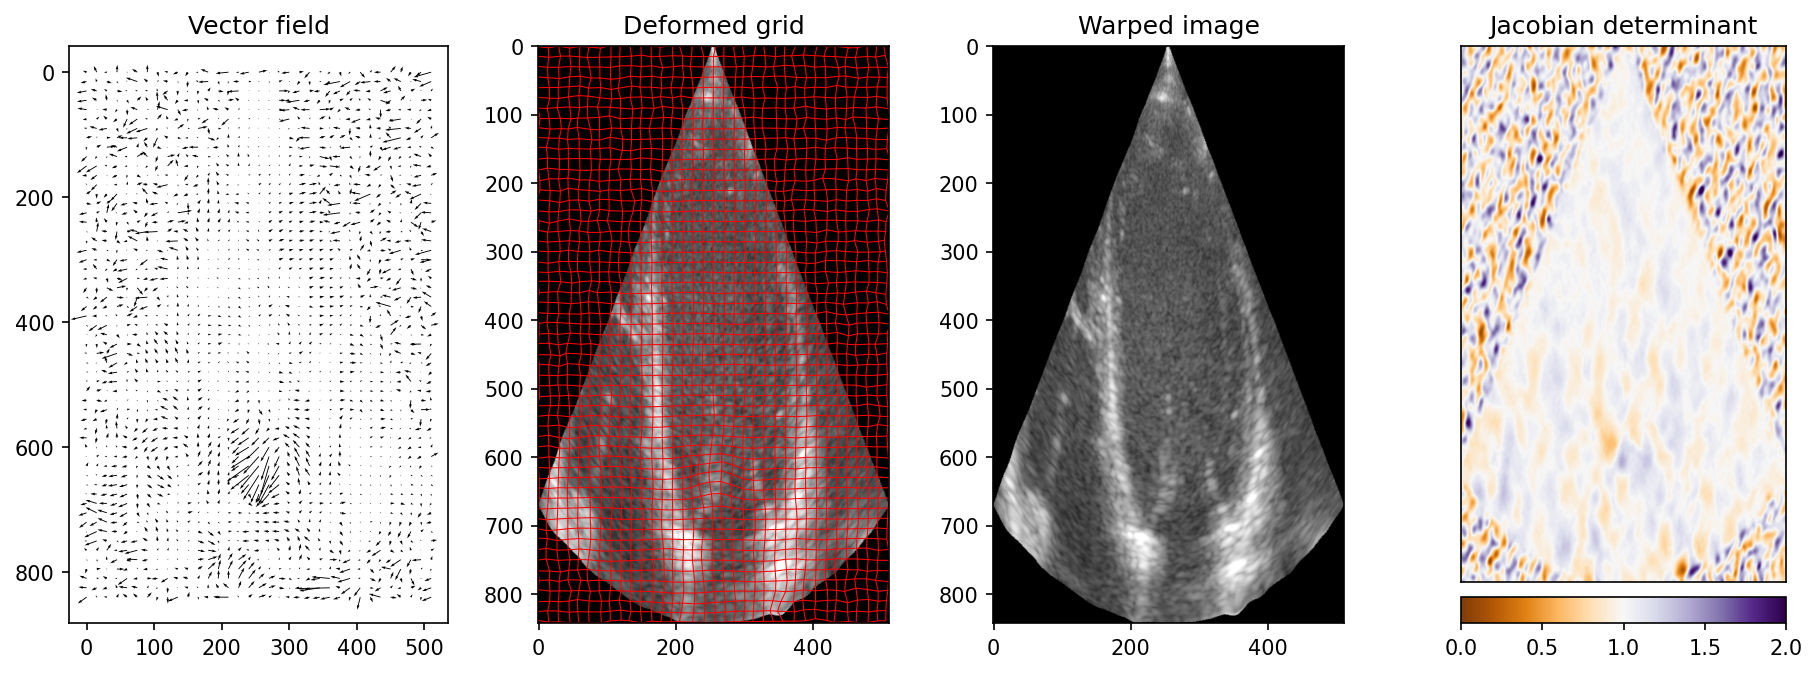

In [189]:
step = 15 # to downsample the grid
x,y = np.meshgrid(np.arange(0, dvf.shape[2]), np.arange(0,dvf.shape[1]))

u,v = dvf[0], dvf[1]

jacobian_1, jacobian_masked_1 = compute_jacobian_determinant(dvf)

# =============================================================================

fig, ax = plt.subplots(1, 4, figsize=(15,5), dpi=150)
ax[0].quiver(x[::step, ::step],y[::step, ::step],u[::step, ::step],v[::step, ::step])
ax[0].invert_yaxis()
ax[0].set_title('Vector field')
plot_grid(u, v, step=step, ax=ax[1], color="red", linewidth=0.5)
ax[1].imshow(warped_img, cmap='gray', vmin=0, vmax=1)
ax[1].set_title('Deformed grid')
ax[2].imshow(warped_img, cmap='gray', vmin=0, vmax=1)
ax[2].set_title('Warped image')
plot_jacobian_determinant(jacobian_1, jacobian_masked_1, ax=ax[3])
ax[3].set_title('Jacobian determinant')

# for a in ax.ravel():
#     a.axis('off')

plt.show()


# Jacobian regularization
Default hyperparameter alpha_jacobian is 0.05

100%|██████████| 2500/2500 [00:26<00:00, 95.96it/s] 


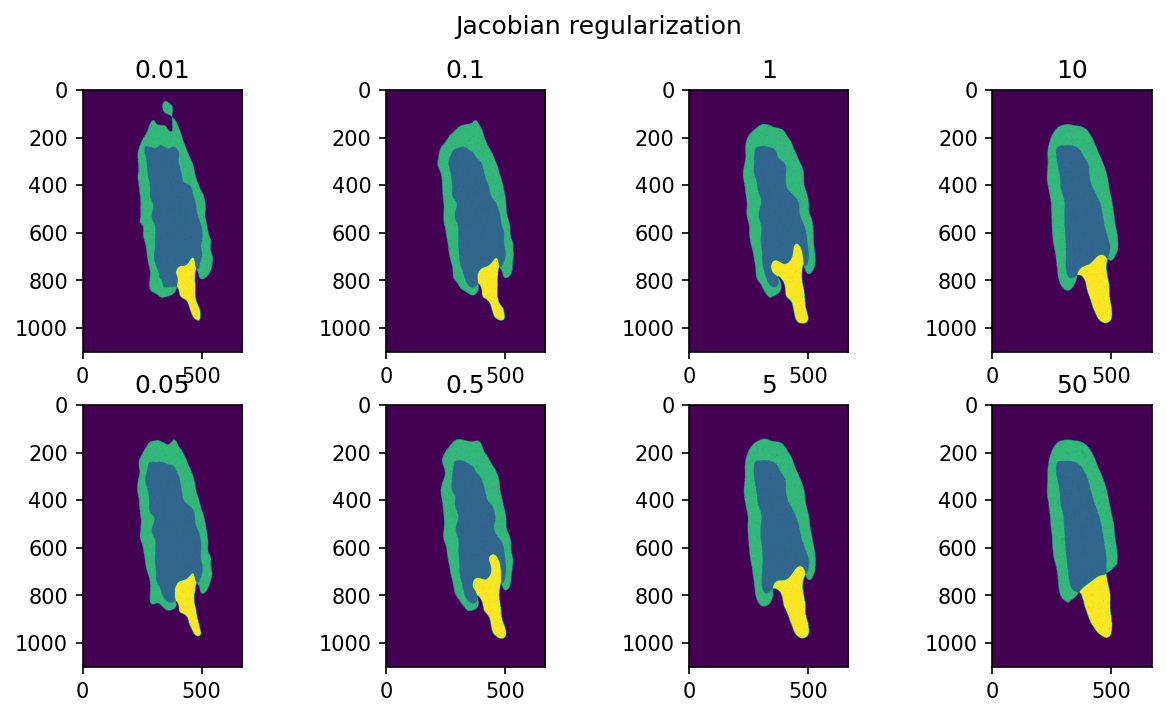

In [ ]:
out_dir = "./CAMUS"
fig, ax = plt.subplots(2, 4, figsize=(10,5), dpi=150)

for i, alpha_jacobian in enumerate([0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]):

    kwargs = {}
    kwargs["verbose"] = False

    kwargs["jacobian_regularization"] = True # this should work. try changing alpha_jacobian
    kwargs["alpha_jacobian"] = alpha_jacobian

    kwargs["hyper_regularization"] = False
    kwargs["bending_regularization"] = False

    kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"
    kwargs["save_folder"] = os.path.join(out_dir, patient_name + '_' + view)
    kwargs["mask"] = None
    kwargs["batch_size"] = 1000 # default is 1000
    kwargs["omega"] = 32 # default is 32

    # --------------- TRAINING ---------------
    ImpReg = models.ImplicitRegistrator(fixed_img, moving_img, **kwargs)
    ImpReg.fit()

    # --------------- INFERENCE ---------------
    coordinate_tensor = make_coordinate_tensor(dims=moving_img.shape)
    coordinate_tensor_transformed = ImpReg.network(coordinate_tensor)
    # Shift coordinates by 1/n * v
    coord_temp = torch.add(coordinate_tensor_transformed, coordinate_tensor)
    warped_mask = ImpReg(coordinate_tensor, moving_image = moving_mask.cuda(), output_shape = moving_img.shape).astype(np.uint8)
    warped_img = ImpReg(coordinate_tensor, moving_image = moving_img.cuda(), output_shape = moving_img.shape).astype(np.uint8)
    
    # --------------- EXTRACT DVF ---------------
    x_indices, y_indices = coord_temp[:, 0],  coord_temp[:, 1],
    input_array = np.zeros_like(moving_img)
    x_indices = (x_indices + 1) * (input_array.shape[0] - 1) * 0.5
    y_indices = (y_indices + 1) * (input_array.shape[1] - 1) * 0.5

    x_indices = x_indices.reshape(input_array.shape).detach().cpu()
    y_indices = y_indices.reshape(input_array.shape).detach().cpu()
    displaced_grid = np.stack([x_indices, y_indices], axis=0)

    # I think if I now subtract an identity grid, I get the dvf
    identity_grid = np.indices(input_array.shape).astype(np.float32)
    dvf = displaced_grid - identity_grid

    # --------------- PLOTTING ---------------
    ax[i%2, i//2].imshow(warped_mask)
    ax[i%2, i//2].set_title(alpha_jacobian)
    fig.suptitle('Jacobian regularization')

# Hyper-elastic regularization

Default alpha_hyper is 0.25

100%|██████████| 2500/2500 [00:33<00:00, 75.72it/s]


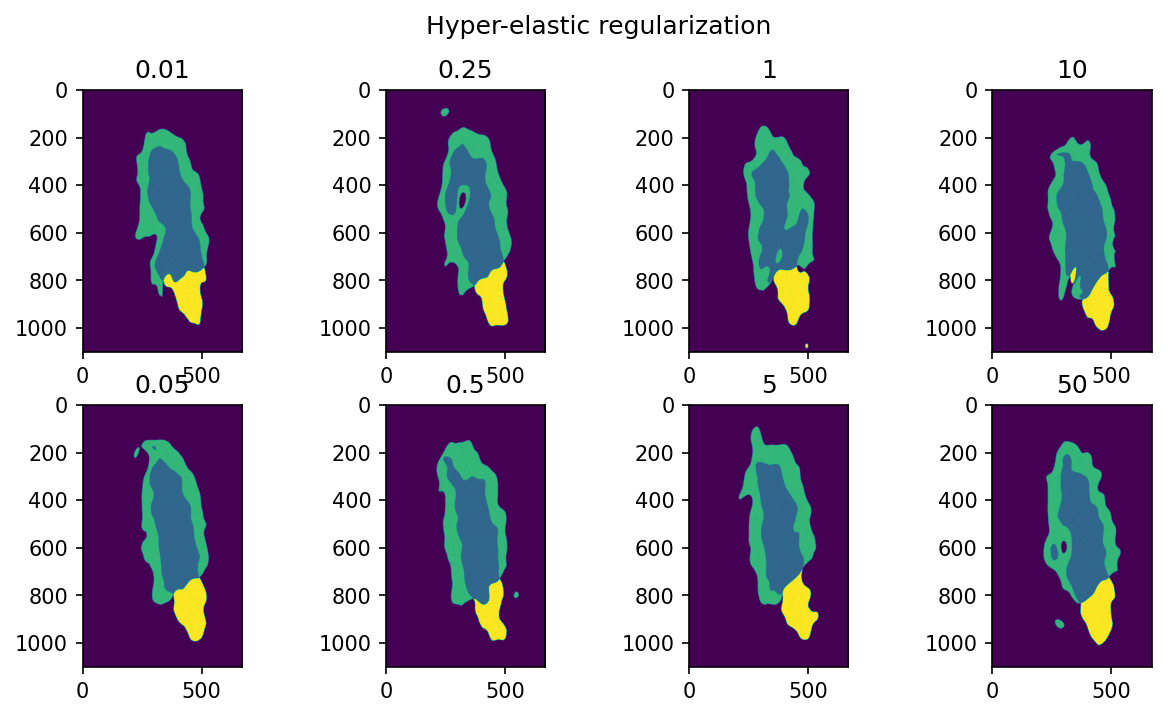

In [ ]:
out_dir = "./CAMUS"
fig, ax = plt.subplots(2, 4, figsize=(10,5), dpi=150)

for i, alpha_hyper in enumerate([0.01, 0.05, 0.25, 0.5, 1, 5, 10, 50]):

    kwargs = {}
    kwargs["verbose"] = False

    kwargs["hyper_regularization"] = True
    kwargs["alpha_hyper"] = alpha_hyper

    kwargs["jacobian_regularization"] = False
    kwargs["bending_regularization"] = False

    kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"
    kwargs["save_folder"] = os.path.join(out_dir, patient_name + '_' + view)
    kwargs["mask"] = None
    kwargs["batch_size"] = 1000 # default is 1000
    kwargs["omega"] = 32 # default is 32

    # --------------- TRAINING ---------------
    ImpReg = models.ImplicitRegistrator(fixed_img, moving_img, **kwargs)
    ImpReg.fit()

    # --------------- INFERENCE ---------------
    coordinate_tensor = make_coordinate_tensor(dims=moving_img.shape)
    coordinate_tensor_transformed = ImpReg.network(coordinate_tensor)
    # Shift coordinates by 1/n * v
    coord_temp = torch.add(coordinate_tensor_transformed, coordinate_tensor)
    warped_mask = ImpReg(coordinate_tensor, moving_image = moving_mask.cuda(), output_shape = moving_img.shape).astype(np.uint8)
    warped_img = ImpReg(coordinate_tensor, moving_image = moving_img.cuda(), output_shape = moving_img.shape).astype(np.uint8)
    
    # --------------- EXTRACT DVF ---------------
    x_indices, y_indices = coord_temp[:, 0],  coord_temp[:, 1],
    input_array = np.zeros_like(moving_img)
    x_indices = (x_indices + 1) * (input_array.shape[0] - 1) * 0.5
    y_indices = (y_indices + 1) * (input_array.shape[1] - 1) * 0.5

    x_indices = x_indices.reshape(input_array.shape).detach().cpu()
    y_indices = y_indices.reshape(input_array.shape).detach().cpu()
    displaced_grid = np.stack([x_indices, y_indices], axis=0)

    # I think if I now subtract an identity grid, I get the dvf
    identity_grid = np.indices(input_array.shape).astype(np.float32)
    dvf = displaced_grid - identity_grid

    # --------------- PLOTTING ---------------
    ax[i%2, i//2].imshow(warped_mask)
    ax[i%2, i//2].set_title(alpha_hyper)
    fig.suptitle('Hyper-elastic regularization')

# Bending energy reguralization

Default alpha_bending is 10

100%|██████████| 2500/2500 [01:03<00:00, 39.49it/s]


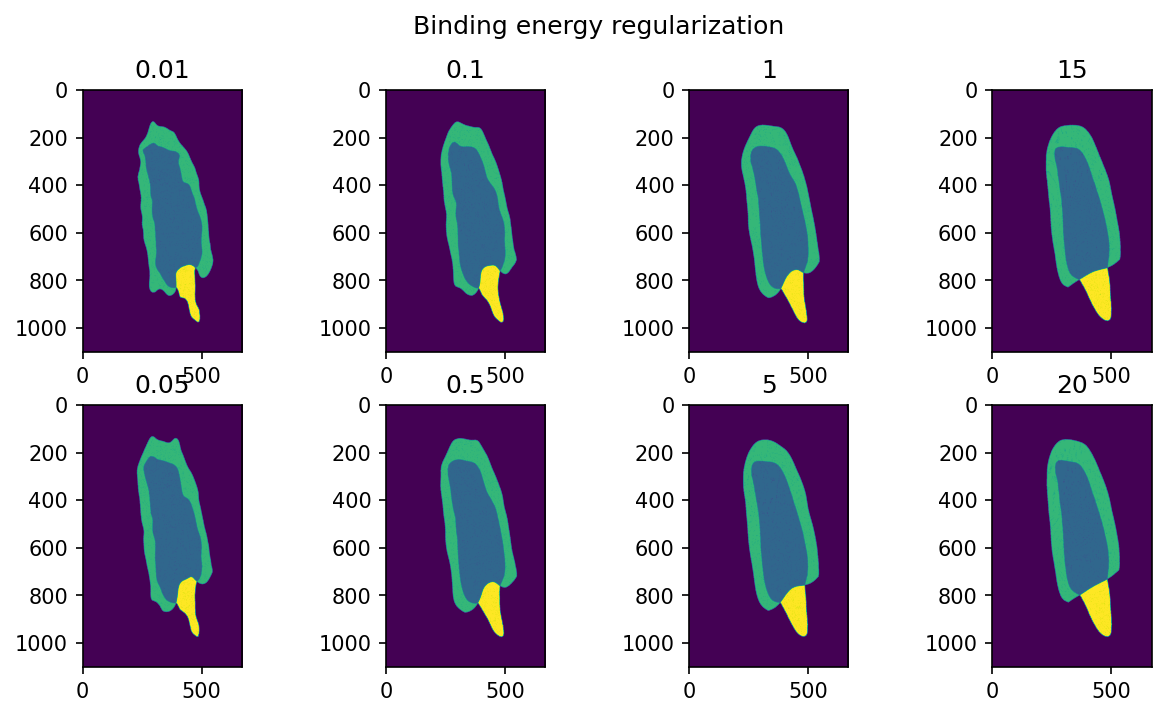

In [ ]:
out_dir = "./CAMUS"
fig, ax = plt.subplots(2, 4, figsize=(10,5), dpi=150)

for i, alpha_bending in enumerate([0.01, 0.05, 0.1, 0.5, 1, 5, 15, 20]):

    kwargs = {}
    kwargs["verbose"] = False

    kwargs["bending_regularization"] = True
    kwargs["alpha_bending"] = alpha_bending

    kwargs["hyper_regularization"] = False
    kwargs["jacobian_regularization"] = False

    kwargs["network_type"] = "SIREN"  # Options are "MLP" and "SIREN"
    kwargs["save_folder"] = os.path.join(out_dir, patient_name + '_' + view)
    kwargs["mask"] = None
    kwargs["batch_size"] = 1000 # default is 1000
    kwargs["omega"] = 32 # default is 32

    # --------------- TRAINING ---------------
    ImpReg = models.ImplicitRegistrator(fixed_img, moving_img, **kwargs)
    ImpReg.fit()

    # --------------- INFERENCE ---------------
    coordinate_tensor = make_coordinate_tensor(dims=moving_img.shape)
    coordinate_tensor_transformed = ImpReg.network(coordinate_tensor)
    # Shift coordinates by 1/n * v
    coord_temp = torch.add(coordinate_tensor_transformed, coordinate_tensor)
    warped_mask = ImpReg(coordinate_tensor, moving_image = moving_mask.cuda(), output_shape = moving_img.shape).astype(np.uint8)
    warped_img = ImpReg(coordinate_tensor, moving_image = moving_img.cuda(), output_shape = moving_img.shape).astype(np.uint8)
    
    # --------------- EXTRACT DVF ---------------
    x_indices, y_indices = coord_temp[:, 0],  coord_temp[:, 1],
    input_array = np.zeros_like(moving_img)
    x_indices = (x_indices + 1) * (input_array.shape[0] - 1) * 0.5
    y_indices = (y_indices + 1) * (input_array.shape[1] - 1) * 0.5

    x_indices = x_indices.reshape(input_array.shape).detach().cpu()
    y_indices = y_indices.reshape(input_array.shape).detach().cpu()
    displaced_grid = np.stack([x_indices, y_indices], axis=0)

    # I think if I now subtract an identity grid, I get the dvf
    identity_grid = np.indices(input_array.shape).astype(np.float32)
    dvf = displaced_grid - identity_grid

    # --------------- PLOTTING ---------------
    ax[i%2, i//2].imshow(warped_mask)
    ax[i%2, i//2].set_title(alpha_bending)
    fig.suptitle('Binding energy regularization')